# INF-510 Computational Numerical Methods
## Fire spread model based on Linear Reaction-Convection-Diffusion Equation
### Daniel San Martín

## Linear Reaction-Convection-Diffusion Equation

The linear reaction-convection-diffusion [1] equation is defined by

\begin{equation}
    \frac{\partial u}{\partial t} = \mu \nabla^2u - \nabla \cdot (u\textbf{v})+au,
\end{equation}

where $u$ can represent the temperature or concentration of chemical species in a domain $\Omega \in \mathbb{R}^n$, $\mu>0$ is the diffusion constant, $\textbf{v}(\textbf{x})=(v_1(\textbf{x}), ..., v_n(\textbf{x}))$ is a velocity field of flow fluid and $a(\textbf{x})$ is a reaction rate.

### Diffusion term

The model is based in the process of particles movement and this term is defined by 

\begin{equation}
    \begin{split}
        \mu \nabla^2u & = \mu\left(\frac{\partial^2 u}{\partial x_1^2} 
            + ... + \frac{\partial^2 u}{\partial x_n^2}\right). \\
    \end{split}
\end{equation}

For $\textbf{x}\in\mathbb{R}^2$ we have
\begin{equation}
    \mu \nabla^2u = \mu\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right).
\end{equation}

### Convection term

The model includes the effect of a vector field $\textbf{v}(\textbf{x})=(v_1(\textbf{x}), ..., v_n(\textbf{x}))$ in the form 

\begin{equation}
    \begin{split}
        \nabla \cdot (u\textbf{v}) & = \sum_{i=1}^n\frac{\partial(uv_i)}{\partial x_i}.
    \end{split}
\end{equation}

For $\textbf{x}\in\mathbb{R}^2$ we have
\begin{equation}
    \begin{split}
        \nabla \cdot (u\textbf{v}) & = \frac{\partial(uv_1)}{\partial x} + \frac{\partial(uv_2)}{\partial y} \\
         & = \frac{\partial u}{\partial x}v_1 + u\frac{\partial v_1}{\partial x} +
             \frac{\partial u}{\partial y}v_2 + u\frac{\partial v_2}{\partial y}
    \end{split}
\end{equation}

### Reaction term

The reaction term is a linear approximation of chemical kinetics and is defined by $au$, where $a$ may be a real number or a scalar field.

<!--\begin{equation}
    au = a(\textbf{x})u(\textbf{x}).
\end{equation}

For $\textbf{x}\in\mathbb{R}^2$ we have $a(x,y)u(x,y)$-->

## Fire spreading

Assuming that we have a scalar field as fuel and a constant wind, we want to model a fire propagation (heat transport) using the PDE as follow

\begin{equation}
    \begin{split}
        \frac{\partial u}{\partial t} & = \mu \nabla^2u - \nabla \cdot (u\textbf{v})+au ~ \text{in} ~ \Omega \\
            u\big|_{\Gamma} & = f \\
            u(x,y,0) & = u_0(x,y).
    \end{split}
\end{equation}

where $\Gamma=\partial\Omega$ is the domain's boundary.

### Numerical Method

To compute the derivatives we use Chebyshev differentiation matrix for spatial domain and for time domain we use Euler's Method [2].

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy.interpolate import interp2d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
# Chebyshev differentiation matrix
def cheb(N):
    if N == 0:
        D = 0
        x = 1
        return D, x
    x = np.cos(np.pi * np.arange(N + 1) / N)
    c = np.hstack((2, np.ones(N - 1), 2)) * ((-1.)**np.arange(N + 1))
    X = np.tile(x, (N + 1, 1)).T
    dX = X - X.T
    D = np.outer(c, 1./c) / (dX + np.eye(N + 1))
    D = D - np.diag(np.sum(D.T, axis=0))
    return D,x

In [3]:
# Plot initial condition
def plotIC(x, y, u):
    plt.subplot(1, 3, 1)
    plt.title("Initial Condition")
    fine = np.linspace(-1, 1, 5*N)
    Xf, Yf = np.meshgrid(fine, fine)
    f = interp2d(x, y, u, kind='cubic')
    u = f(fine, fine)
    #count = plt.contourf(Xf, Yf, u, cmap=cm.jet)
    count = plt.imshow(u, cmap=cm.jet, extent=[-1, 1, -1, 1], origin="lower", interpolation="gaussian")
    plt.xlabel("x")
    plt.ylabel("y")
    return count

In [4]:
# Plot fluid flow
def plotFluid(Xv, Yv, V1, V2):
    plt.subplot(1, 3, 2)
    plt.title("Fluid")
    if (np.all(V1 == 0) and np.all(V2 == 0)): return
    quiv = plt.quiver(Xv, Yv, V1, V2)
    plt.xlabel("x")
    plt.ylabel("y")
    return quiv

In [5]:
# Plot reaction rate
def plotReaction(x, y, a):
    plt.subplot(1, 3, 3)
    plt.title("Reaction Rate")
    fine = np.linspace(-1, 1, 5*N)
    Xf, Yf = np.meshgrid(fine, fine)
    f = interp2d(x, y, a, kind='cubic')
    a = f(fine, fine)
    count = plt.contourf(Xf, Yf, a, cmap=cm.jet)
    plt.xlabel("x")
    plt.ylabel("y")
    return count

In [6]:
def plot3(W, V1, V2, A):
    fig = plt.figure(figsize=(16, 4))
    ic = plotIC(X, Y, W)
    fig.colorbar(ic)        
    fl = plotFluid(Xv, Yv, V1, V2)
    rr = plotReaction(X, Y, A)        
    fig.colorbar(rr)
    plt.tight_layout()
    plt.show()

In [7]:
# Plot solution
def plot(t, u, d, i, elev, azim):
    fine = np.linspace(-1, 1, 4*N)
    Xf, Yf = np.meshgrid(fine, fine)
    f = interp2d(x, y, u[i], kind='cubic')
    v = f(fine, fine)    
    vmn, vmx = np.min(u), np.max(u)
    fig = plt.figure(figsize=(10, 8))
    if d == 1:        
        ax = fig.gca(projection='3d')                        
        surf = ax.plot_surface(Xf, Yf, v, rstride=1, cstride=1, cmap=cm.jet)#, vmin=vmn, vmax=vmx)  
        fig.colorbar(surf)
        ax.view_init(elev=elev, azim=azim)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("u(x,y)")
        ax.set_zlim([vmn, vmx])
    else:        
        cont = plt.contourf(Xf, Yf, v, cmap=cm.jet)#, vmin=vmn, vmax=vmx, antialiased=True)
        fig.colorbar(cont)
        
    plt.title("$t$: " + "{:10.2f}".format(t[i]))
    plt.show()

In [8]:
# Helper to build reaction rate
# Gaussian basis
def G(x, y):
    return np.exp(-(x**2 + y**2))

# Superposition of gaussians based in https://commons.wikimedia.org/wiki/File:Scalar_field.png
def S(x, y):
    return G(2*x, 2*y) + 0.8 * G(2*x + 1.25, 2*y + 1.25) + 0.5 * G(2*x - 1.25, 4*y + 1.25) \
        - 0.5 * G(3*x - 1.25, 3*y - 1.25) + 0.35 * G(2*x + 1.25, 2*y - 1.25) \
        + 0.8 * G(x - 1.25, 3*y + 1.5) + 1.2 * G(x + 1.25, 3*y - 1.85)

In [34]:
# Use Euler for time domain
def solvePDE(mu, dt, T, A, V1, V2, W):
    u = [W]
    t = [0]

    # Euler
    for n in range(T):

        diff = mu*(np.dot(W, D2x.T) + np.dot(D2y, W))    
        conv = np.dot(np.dot(W, Dx.T), V1) + np.dot(W, np.dot(V1, Dx.T)) \
            + np.dot(np.dot(Dy, W), V2) + np.dot(W, np.dot(Dy, V2))
        reac = np.dot(A, W)

        W = W + dt*(diff - conv + reac) 

        # Border condition, f=0
        W[0,:] = np.zeros(N+1)
        W[-1,:] = np.zeros(N+1)
        W[:,0] = np.zeros(N+1)
        W[:,-1] = np.zeros(N+1)

        if (n % 2 == 0): # keep some plots
            u.append(W)
            t.append(n*dt)
            
    return t, u

In [10]:
# Plot experiment using widgets
def plotExperiment(t, u):
    slider = widgets.IntSlider(
        value=0, 
        min=0, 
        max=len(t)-1, 
        step=1, 
        description='Time step:',
        continuous_update=False,
        readout=True,
        readout_format='d'
    )

    ele = widgets.IntSlider(
        value=30,
        min=0,
        max=90,
        step=10,
        description='Elevation:'
    )

    azi = widgets.IntSlider(
        value=220,
        min=220,
        max=270,
        step=10,
        description='Azimuth:'
    )

    drop = widgets.Dropdown(
        options={'Contour': 0, 'Surface': 1},
        value=0,
        description='Plot:',
    )
    
    widgets.interact(plot, t=widgets.fixed(t), u=widgets.fixed(u), d=drop, i=slider, elev=ele, azim=azi)

In [11]:
# Solve PDE for parameters
def experiment(param):
    A = param['a'](X, Y)
    V1, V2 = param['v'][0](X, Y), param['v'][1](X, Y)
    W = param['u0'](X, Y)  
    
    t, u = solvePDE(
        param['mu'], 
        param['dt'], 
        param['T'], 
        A, 
        V1, 
        V2,
        W
    )
    return t, u

In [12]:
# Fixed variables
N = 20

# x variable in [-1,1], Chebyshev
Nx = N; Dx, x = cheb(Nx)
D2x = np.dot(Dx, Dx);

# y variable in [-1,1], Chebyshev
Ny = N; Dy, y = cheb(Ny) 
D2y = np.dot(Dy, Dy)

# Grids
X, Y = np.meshgrid(x,y)
Xv, Yv = np.mgrid[-1:1:21j, -1:1:21j]

# Finer mesh
fine = np.linspace(-1, 1, 4*N)
Xf, Yf = np.meshgrid(fine, fine)

In [13]:
# Reaction Rate
a = lambda x, y: 10*S(X, Y)

# Vectorial field
v1 = lambda x, y: 1
v2 = lambda x, y: np.sin(x**2 + y**2)

# Initial condition
u0 = lambda x, y: 1e3*np.exp(-40*((x+.5)**2 + (y+.5)**2))

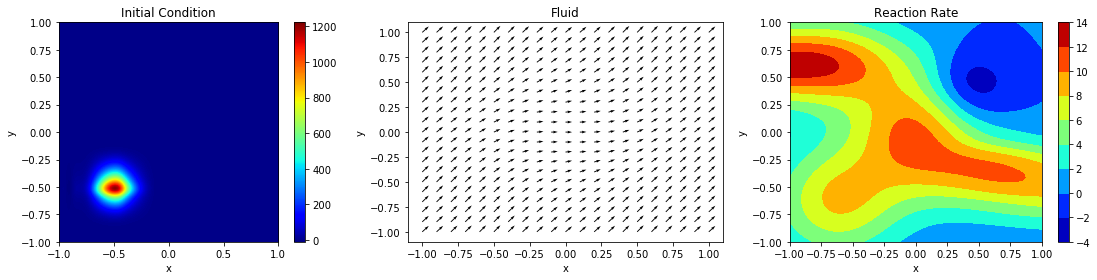

In [14]:
plot3(u0(X, Y), v1(X, Y), v2(X, Y), a(X, Y))

## Experiments

### Only Diffusion

In [15]:
param1 = {
    'mu': .8,
    'dt': 1e-5,
    'T': 4000,
    'a': np.vectorize(lambda x, y: 0),
    'v': (np.vectorize(lambda x, y: 0), np.vectorize(lambda x, y: 0)),
    'u0': u0
}

In [16]:
t1, u1 = experiment(param1)

In [17]:
plotExperiment(t1, u1)

interactive(children=(Dropdown(description='Plot:', options={'Contour': 0, 'Surface': 1}, value=0), IntSlider(value=0, continuous_update=False, description='Time step:', max=2000), IntSlider(value=30, description='Elevation:', max=90, step=10), IntSlider(value=220, description='Azimuth:', max=270, min=220, step=10), Output()), _dom_classes=('widget-interact',))

This experiment shows how the temperature diffuses over the domain.

### Diffusion + Convection

In [35]:
param2 = {
    'mu': .8,
    'dt': 1e-5,
    'T': 4000,
    'a': np.vectorize(lambda x, y: 0),
    'v': (v1, v2),
    'u0': u0
}

In [36]:
t2, u2 = experiment(param2)

In [37]:
plotExperiment(t2, u2)

interactive(children=(Dropdown(description='Plot:', options={'Contour': 0, 'Surface': 1}, value=0), IntSlider(value=0, continuous_update=False, description='Time step:', max=2000), IntSlider(value=30, description='Elevation:', max=90, step=10), IntSlider(value=220, description='Azimuth:', max=270, min=220, step=10), Output()), _dom_classes=('widget-interact',))

In this experiment we note the effect of vector field, where the heat moves in direction of flow.

### Diffusion + Reaction

In [21]:
param3 = {
    'mu': .8,
    'dt': 1e-5,
    'T': 4000,
    'a': a,
    'v': (np.vectorize(lambda x, y: 0), np.vectorize(lambda x, y: 0)),
    'u0': u0
}

In [22]:
t3, u3 = experiment(param3)

In [23]:
plotExperiment(t3, u3)

interactive(children=(Dropdown(description='Plot:', options={'Contour': 0, 'Surface': 1}, value=0), IntSlider(value=0, continuous_update=False, description='Time step:', max=2000), IntSlider(value=30, description='Elevation:', max=90, step=10), IntSlider(value=220, description='Azimuth:', max=270, min=220, step=10), Output()), _dom_classes=('widget-interact',))

Here we note the temperature moves to zones with high reaction rate.

### Diffusion + Convection + Reaction

In [24]:
param4 = {
    'mu': .8,
    'dt': 1e-5,
    'T': 4000,
    'a': a,
    'v': (v1, v2),
    'u0': u0
}

In [25]:
t4, u4 = experiment(param4)

In [26]:
plotExperiment(t4, u4)

interactive(children=(Dropdown(description='Plot:', options={'Contour': 0, 'Surface': 1}, value=0), IntSlider(value=0, continuous_update=False, description='Time step:', max=2000), IntSlider(value=30, description='Elevation:', max=90, step=10), IntSlider(value=220, description='Azimuth:', max=270, min=220, step=10), Output()), _dom_classes=('widget-interact',))

We note in this experiment the effect of reaction rate together with the vectorial field. The first elevates the temperature in zones with high reaction rate and the second one "moves" the heat, slightly increasing the temperature in the direction of the field.

## References

1. Liu, W. (2009). Elementary feedback stabilization of the linear reaction-convection-diffusion equation and the wave equation (Vol. 66). Springer Science & Business Media.
2. Trefethen, L. N. (2000). Spectral methods in MATLAB (Vol. 10). Siam.